**MAESTRÍA EN INTELIGENCIA ARTIFICIAL APLICADA**

**Curso: TC4029 - Ciencia y analítica de datos**

Tecnológico de Monterrey

Prof Grettel Barceló Alonso

**Semana 8**
Regresión Lineal

---

*   Estudiante 1: Erik Morales Hinojosa
*   MATRÍCULA del estudiante 1: A01795110
*   Estudiante 2: Alejandra Berenice Vega López
*   MATRÍCULA de la estudiante 2: A01795415
*   Estudiante 3: Israel Luján González
*   MATRÍCULA del estudiante 3: A01794693
*   Estudiante 4: Eduardo Selim Martínez Mayorga
*   MATRÍCULA del estudiante 4: A01795167

In [1]:
"""
from google.colab import drive
drive.mount('/content/drive')
"""

"\nfrom google.colab import drive\ndrive.mount('/content/drive')\n"

In [2]:
"""
import os
DIR = "/content/drive/MyDrive/Colab Notebooks/MNA/TC4029 - Ciencia y analítica de datos/Semana 7/Actividad7_PCA"
os.chdir(DIR)
"""

'\nimport os\nDIR = "/content/drive/MyDrive/Colab Notebooks/MNA/TC4029 - Ciencia y analítica de datos/Semana 7/Actividad7_PCA"\nos.chdir(DIR)\n'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import ttest_ind

import math

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

In [4]:
# El archivo "insurance.csv" se encuentra en la misma
# carpeta que este Jupyter Notebook

insurance_df = pd.read_csv('insurance.csv')

# Se verifica la lectura y definición del dataframe
insurance_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
# Observamos el número de renglones y columnas del dataframe
insurance_df.shape

(1338, 7)

# **Parte 1**. EDA

Efectúa una exploración inicial de los datos a través de:

1a) Estadísticas descriptivas para todas las variables del dataframe.

Primeo se verá de qué tipo es cada columna/variable:

In [6]:
# Obtenemos los tipos de las columnas y guardamos la 
# serie en un objeto
x = insurance_df.dtypes

# Convertimos la serie guardada en un dataframe
df_columnas = x.apply(pd.Series)

# Se convierte el índice en un columna y se toma a los índices
# como los números naturales
df_columnas.reset_index(inplace=True)

#Cambiamos el nombre de las columnas para mayor entendimiento
df_columnas.columns = ['variable', 'tipo']

# Ahora sí se puede contar cuántas columnas hay de cada tipo
df_columnas['tipo'].value_counts()

object     3
int64      2
float64    2
Name: tipo, dtype: int64

Esto significa que hay

+ 2 variables del tipo float64 (i.e. que toman valores reales)
+ 2 variables del tipo int64 (i.e. que toman valores enteros)
+ 3 variables del tipo object (i.e. que toman valores strings)

Veamos los descriptivos de las variables numéricas:

In [7]:
insurance_df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Veamos los descriptivos de las variables categóricas:

In [8]:
# Se obtienen conteos, número de valores únicos, moda y
# y su frecuencia para las variables no numéricas
insurance_df.describe(include = 'object')

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


Como parte del análisis exploratorio, primero se hará un pairplot para las variables numéricas. Esto nos permitirá ver si existe alguna relación entre ellas. En las gráficas sobre la "diagonal" se muestra un histograma de cada variable numérica. Las gráficas "fuera de la diagonal" son diagramas de dispersión de todas las posibles parejas de variables numéricas.

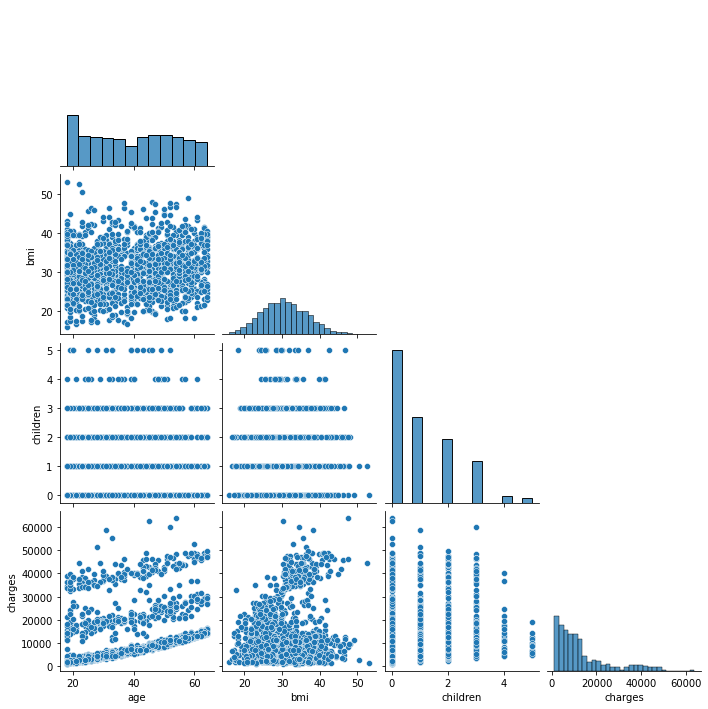

In [9]:
# Se genera un pairplot para las variables numéricas
sns.pairplot(insurance_df, corner=True);

La variable `charges` muestra una aparente cola pesada que se analizará con más detalle más adelante.

Solo considerando las variables numéricas, no sé ve una relación aparente entre éstas. Por tanto se incorporarán las variables categóricas.

### Para la variable `sex`

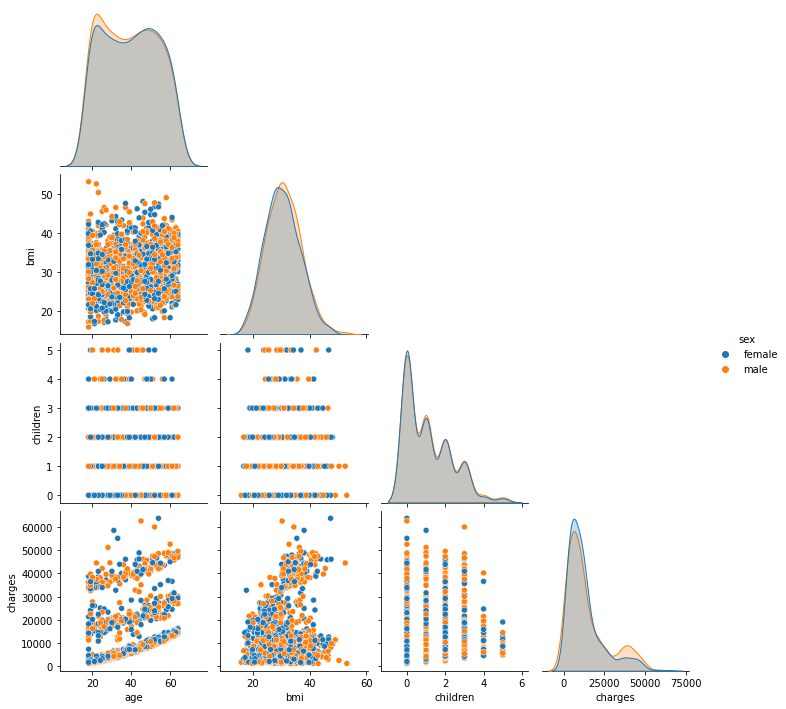

In [10]:
# Se genera un pairplot para las variables numéricas
# Pero divididas por 'sex'
sns.pairplot(insurance_df, hue = "sex", corner = True);

Considerando la variable `sex`, las cuatro variables numéricas no muestran un comportamiento diferente en su distribución, ni en sus relaciones por pares. Excepto quizá, una ligera diferencia en la colas de la variable `charges`: para hombres hay un comportamiento bimodal más evidente. Se analizará éste más adelante.

### Para la variable `smoker`

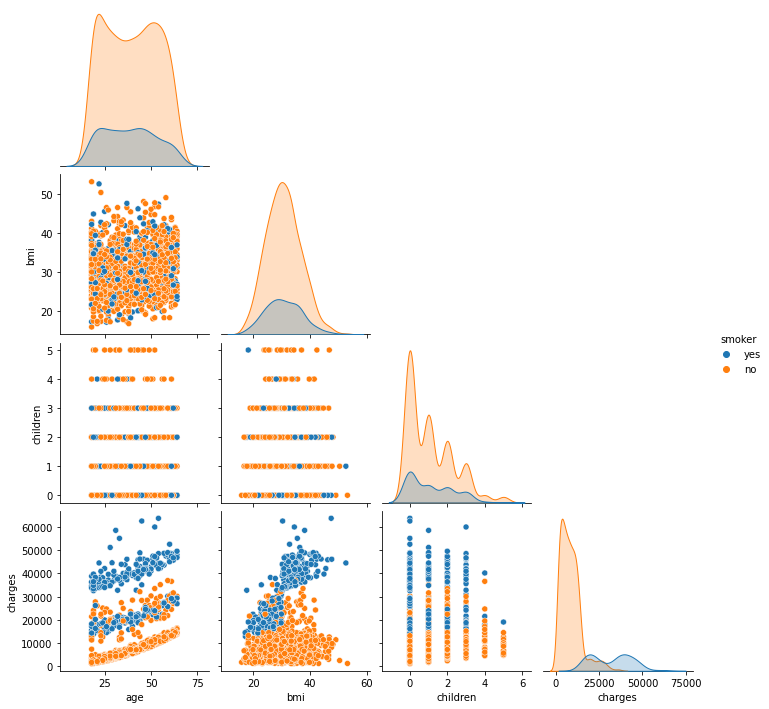

In [11]:
# Se genera un pairplot para las variables numéricas
# Pero divididas por 'smoker'
sns.pairplot(insurance_df, hue = "smoker", corner = True);

Considerando la variable `smoker`, hay algunos hallazgos interesante de analizar.

+ Hay considerablemente más no-fumadores que fumadores (gráficas de la diagonal)
+ Las variables `age`, `bmi` y `children` parecen no ser muy diferentes entre fumadores y no-fumadores (las gráficas en la diagonal muestran la misma forma, aunque escalada por la diferencia de frecuencias entre fumadores y no-fumadores). Sin embargo, la variable `charges` si tiene una distribución diferente dependiendo de sus hábitos de fumar. Se analizará esta posible relación más adelante.
+ Las relaciones `bmi` & `age`, `children` & `age` y `children` & `bmi` parecen no ser afectadas por la presencia de la variable `smoker`.
+ Todas las relaciones con `charges` sí son diferenciadas con la presencia de fumadores. En general, los fumadores tienen valores más altos de `charges` que los no-fumadores. Se analizará esta posible relación más adelante.

### Para la variable `region`

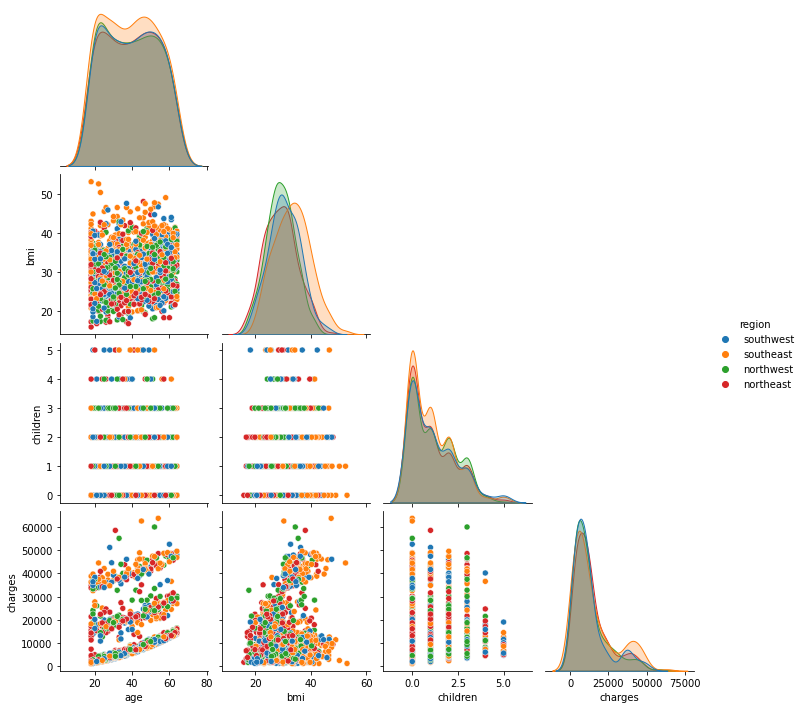

In [12]:
# Se genera un pairplot
sns.pairplot(insurance_df, hue = "region", corner = True);

Considerando la variable `region`, las cuatro variables numéricas aparentemente no muestran un comportamiento diferente en su distribución (gráficas de la diagonal), ni en sus relaciones por pares. Excepto quizá, una ligera diferencia en la colas de la variable `charges`: para sur-este y sur-oeste hay un comportamiento bimodal más evidente. Se analizará éste más adelante.

1b) Búsqueda de valores faltantes.

In [13]:
# Se obtiene el número de NaNs
insurance_df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Es decir, que el dataframe **no tiene valores faltantes**

1c) Histrogramas y boxplots para las variables cuantitativas y diagramas de barras con la frecuencia para las variables categóricas. 

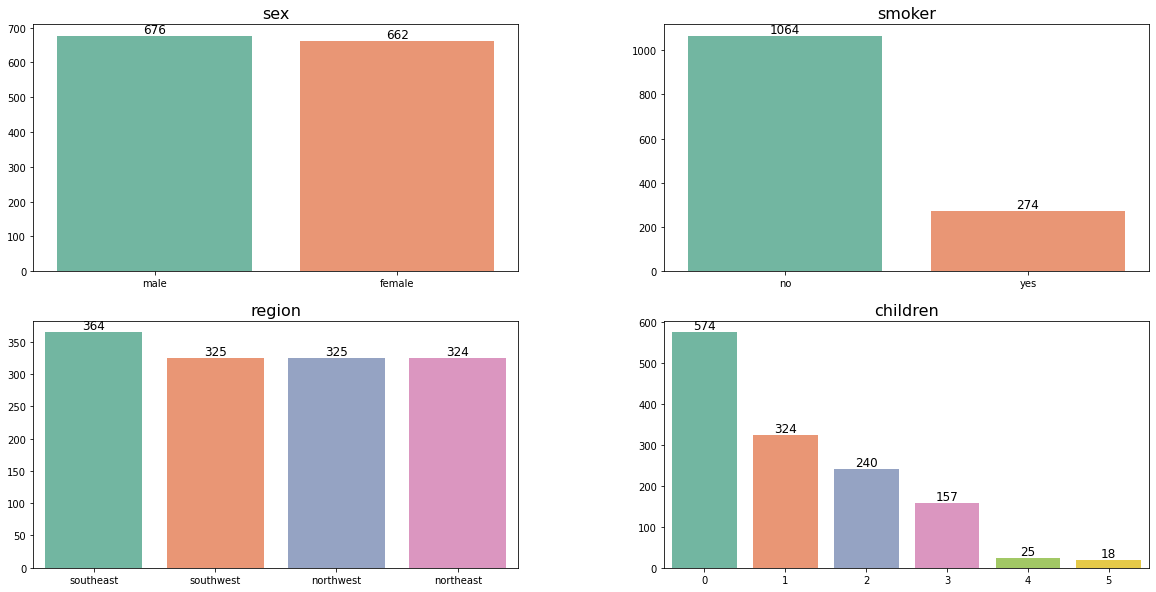

In [14]:
df = insurance_df

cols_de_interes = ['sex', 'smoker', 'region', 'children']

fig, axes = plt.subplots(2,2, figsize=(20,10))
plt.subplots_adjust(wspace=0.3)
axes = axes.ravel()

for col, ax in zip(df[cols_de_interes], axes):
    ax.set_title(f'{col}', fontdict={'size': 16})
    #ax.set(title=f'{col}', xlabel=None)
    #sns.countplot(x = col, ax=ax, data = df)
    s = df[col].value_counts()
    #s = df[col].value_counts().rename_axis(' ').rename('count')
    sns.barplot(ax=ax, x=s.index, y=s.values, order=s.index,
                palette='Set2')
    ax.bar_label(ax.containers[0], fontsize=12)

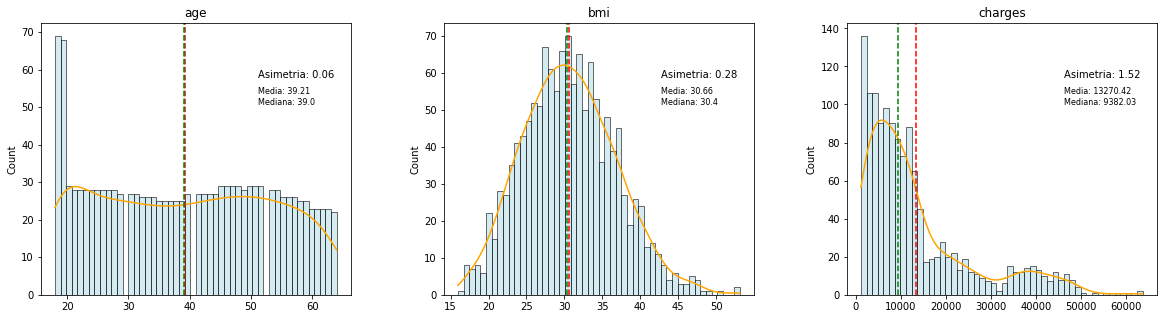

In [15]:
cols_de_interes = ['age', 'bmi', 'charges']

fig, axes = plt.subplots(1,3, figsize=(20,5))
plt.subplots_adjust(wspace=0.3)
axes = axes.ravel()
for col, ax in zip(df[cols_de_interes], axes):
  sns.histplot(x=df[col], ax=ax, bins=50, kde=True,
               color="lightblue")
  ax.set(title=f'{col}', xlabel=None)
  ax.lines[0].set_color('orange')
  mean = round(df[col].mean(),2)
  ax.axvline(mean, color='red', linestyle='dashed', label="Media")
  median = round(df[col].median(),2)
  ax.axvline(median, color='green', linestyle='dashed', label="Mediana")
  ax.annotate('Media: {} \nMediana: {}'.format(mean, median),
              xy=(0.70, 0.70), xycoords='axes fraction',
              fontsize=8, ha='left')
  asim = round(df[col].skew(),2)
  ax.annotate('Asimetria: {}'.format(asim), xy=(0.70, 0.80), 
              xycoords='axes fraction', fontsize=10, ha='left')

Para responder los siguientes cuestionamientos, genera los gráficos indicados:

2a) ¿Hay diferencias significativas de las primas según el sexo? Compara la distribución de la variable `charges` por medio de un boxplot. 

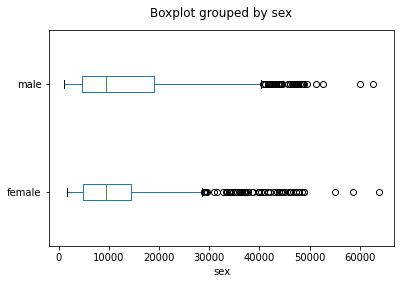

In [16]:
graf = df.boxplot(by = 'sex',
           column = ['charges'],
           grid = False, vert=False)

# Axis details
graf.set_title(" ");

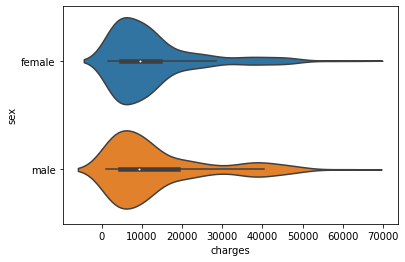

In [17]:
# Violinplots con respecto a las categorías de la variable
# 'sex'
sns.violinplot(y = 'sex', x = 'charges',
              data = df);

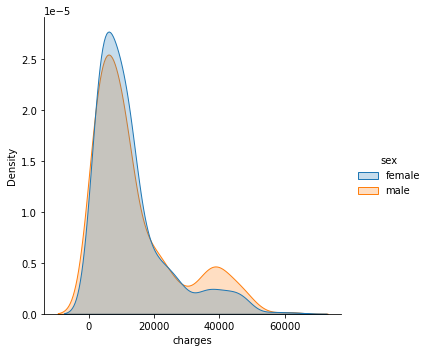

In [18]:
sns.displot(x = "charges", hue = "sex",
            kind="kde", data = df, fill=True);

Se puede observar que para una prima aproximada de 40000, hay más hombres que mujeres que pagan dicho nivel de prima. Antes de 30000, los comportamientos de primaje para ambos géneros son similares.

Se realizará una prueba $t$ para verificar si existe dicha diferencia entre los primajes.

In [19]:
# Se obtienen los `charges` para cada género
group_1_data = df[df['sex'] == 'female']['charges'].dropna()
group_2_data = df[df['sex'] == 'male']['charges'].dropna()

# Se obtiene el p-value de la prueba t
p_value = ttest_ind(group_1_data,group_2_data).pvalue

print('p-value de la prueba t: {}'.format(p_value))

p-value de la prueba t: 0.03613272100592976


De acuerdo a la documentación de función `ttest_ind`: *"A p-value larger than a chosen threshold (e.g. 5% or 1%) indicates that our observation is not so unlikely to have occurred by chance. Therefore, we do not reject the null hypothesis of equal population means. If the p-value is smaller than our threshold, then we have evidence against the null hypothesis of equal population means."*

Para un nivel de confianza del 5%, como el p-value es menor que 0.05, se tiene evidencia contra la hipótesis de que ambas poblaciones tienen las mismas medias.

2b) Crea un diagrama de dispersión de `charges` versus el `bmi` que incorpore la distinción por las categorías `smoker` y `children` (tip: utiliza el parámetro `size`) ¿Hay alguna conclusión importante que se derive del gráfico? 

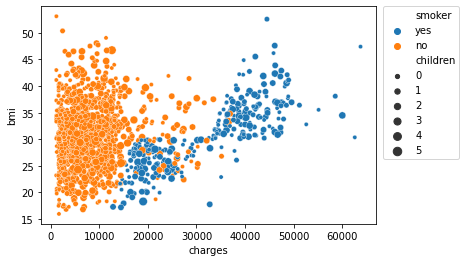

In [20]:
sns.scatterplot(data = df,
                x = "charges", y="bmi",
                hue = "smoker", size = "children")
plt.legend(bbox_to_anchor=(1.25, 1),
           loc = 'upper right', borderaxespad=0);

Dada la cantidad de puntos y que el tamaño de punto varía con respecto al número de hijos, visualmente no se alcanza a notar si efectivamente el número de hijos influye en la relación entre `charges`, `bmi` y `smoker`. Por tanto, se hará una variación de esta gráfica.

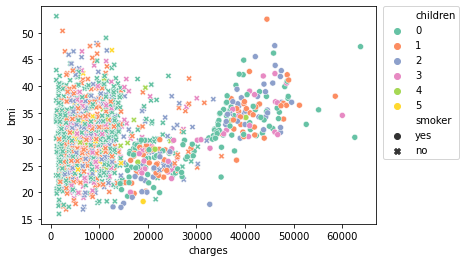

In [21]:
sns.scatterplot(data = df,
                x = "charges", y="bmi",
                hue = "children", style = "smoker",
                palette='Set2')

plt.legend(bbox_to_anchor=(1.25, 1),
           loc = 'upper right', borderaxespad=0);

Se puede notar que no hay una diferenciación evidente a partir del número de hijos, ya que se pueden ver todos los colores sin algún patrón aparente entre fumadores (círculo) y no-fumadores (cruz). Entonces, la relacón que sí es evidente es la basada en sus hábitos de fumar.

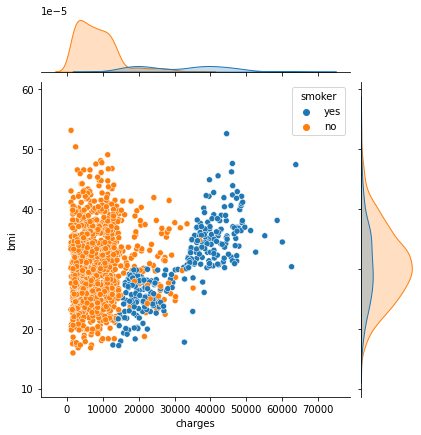

In [22]:
sns.jointplot(data = df,
              x = "charges", y="bmi", hue = "smoker");

2c) Elabora un mapa de calor que muestre la correlación de las variables numéricas. 

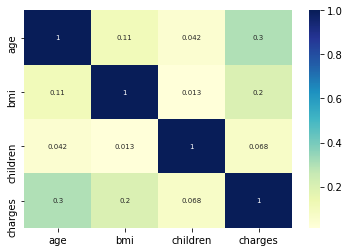

In [23]:
# Se construye el mapa de calor a partir de las correlaciones
# Pero se le agregan las leyendas de las correlaciones
# para mejor visualización
sns.heatmap(df.corr(),
            annot=True, annot_kws={"fontsize":7},
            cmap="YlGnBu");

Obtén un dataframe con las observaciones que tengan valores atípicos en `charges`. 

3a) ¿Cuál es el promedio de `age` y de `bmi`? 

In [24]:
# Primero, se obtiene un dataframe con las observaciones que 
# tienen valores atípicos en `charges`

# Se calculan los cuartiles 1 y 3 de la variable 'charges'
percentile_25 = df['charges'].quantile(0.25)
percentile_75 = df['charges'].quantile(0.75)

# Se calcula el rango intercuartil
iqr = percentile_75 - percentile_25

# Se define el límite superior como el cuartil 3 más
# 1.5 veces el rango intercuartil
upper_limit = percentile_75 + 1.5 * iqr

# Se define el límite inferior como el cuartil 1 menos
# 1.5 veces el rango intercuartil
lower_limit = percentile_25 - 1.5 * iqr

# Se filtran los valores debajo del límite inferior
# y los de arriba del límite superior
IQR_outliers_charges = df[(df['charges'] < lower_limit) | (df['charges'] > upper_limit)]

In [25]:
# Se muestran los outliers
IQR_outliers_charges

,age,sex,bmi,children,smoker,region,charges
14,27,male,42.130,0,yes,southeast,39611.75770
19,30,male,35.300,0,yes,southwest,36837.46700
23,34,female,31.920,1,yes,northeast,37701.87680
29,31,male,36.300,2,yes,southwest,38711.00000
30,22,male,35.600,0,yes,southwest,35585.57600
...,...,...,...,...,...,...,...
1300,45,male,30.360,0,yes,southeast,62592.87309
1301,62,male,30.875,3,yes,northwest,46718.16325
1303,43,male,27.800,0,yes,southwest,37829.72420
1313,19,female,34.700,2,yes,southwest,36397.57600


In [26]:
# Se obtienen los promedios de `age` y de `bmi` en estas
# observaciones atípicas

IQR_outliers_charges.describe().loc['mean'][['age','bmi']]

age    41.079137
bmi    35.564604
Name: mean, dtype: float64

3b) ¿Qué porcentaje de estas observaciones se corresponden a mujeres y a hombres? ¿A fumadores y no fumadores? 

In [27]:
num_outliers = len(IQR_outliers_charges)

(IQR_outliers_charges['sex'].value_counts())/num_outliers

male      0.640288
female    0.359712
Name: sex, dtype: float64

In [28]:
(IQR_outliers_charges['smoker'].value_counts())/num_outliers

yes    0.978417
no     0.021583
Name: smoker, dtype: float64

# **Parte 2**. Preprocesamiento

4. Separa las variables del dataframe: en `X` coloca los predictores y en `y` la variable de respuesta o salida (`charges`). 

In [29]:
# Se obtiene la lista de las columnas del dataframe
lista_columnas = insurance_df.columns.tolist()

# Se elimina la columna 'charges' pues es la variable objetivo
lista_columnas.remove("charges")

In [30]:
lista_columnas

['age', 'sex', 'bmi', 'children', 'smoker', 'region']

In [31]:
# Se definen los predictores a considerar, tanto numéricos
# como categóricos
predictores_categ = ['smoker', 'sex']
predictores_num = ['age','bmi','children']

In [32]:
# Se consruye el dataset de las variables predictoras
X = insurance_df[predictores_num + predictores_categ]

# Se consruye el dataset de la variable de salida
y = insurance_df['charges']

In [33]:
X.head()

,age,bmi,children,smoker,sex
0,19,27.900,0,yes,female
1,18,33.770,1,no,male
2,28,33.000,3,no,male
3,33,22.705,0,no,male
4,32,28.880,0,no,male


In [34]:
y.head()

0    16884.92400
1     1725.55230
2     4449.46200
3    21984.47061
4     3866.85520
Name: charges, dtype: float64

5. Divide el conjunto en entrenamiento y prueba (80:20) considerando:


*   El parámetro `random_state` con el valor de 1 para garantizar reproducibilidad.
*   Analiza los diagramas de barras obtenidos en el ejercicio 1c. Con los resultados observados, es conveniente usar la variable `smoker` en la estrategia de estratificación.
*   Como ya tienes separadas en `X` e `y` los predictores y salida, consulta cómo ejecutar la función `train_test_split()` para obtener `Xtrain, Xtest, ytrain, ytest` en una única instrucción. 

In [35]:
# Se construyen las muestras de entranamiento y prueba
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y,
                                                train_size = 0.8,
                                                random_state = 1)

In [36]:
# Verificación
print(len(Xtrain) + len(Xtest))
print(len(X))

1338
1338


6. Prepara un transformador, denominado `preprocessing`, para aplicar escalamiento *MinMax* a los predictores numéricos y codificación *one-hot* a los categóricas.

In [37]:
# Se define el preprocesador one-hot
preproceso_categorico = OneHotEncoder()

# Se define el preprocesador MinMax
preproceso_numerico = MinMaxScaler()

# Se define el transformador que incluye a ambos preprocesadores
preprocessing = ColumnTransformer(
    [("OneHot", preproceso_categorico, predictores_categ),
     ("EscMinMax", preproceso_numerico, predictores_num),
    ]
)

In [38]:
# Se observa el objeto transformer
# En JupyterNotebook muestra una representación gráfica informativa
preprocessing

ColumnTransformer(transformers=[('OneHot', OneHotEncoder(), ['smoker', 'sex']),
                                ('EscMinMax', MinMaxScaler(),
                                 ['age', 'bmi', 'children'])])


# **Parte 3**. Entrenando y evaluando el modelo de RL

7. Ejecuta un pipeline con el transformador creado y el algoritmo de regresión lineal para entrenar un modelo denominado `lr_model`. 

Evalúa el modelo en el conjunto de prueba y obtén la raíz del error cuadrático medio (`RMSE`) y la métrica `R` cuadrado ($R^2$). Aunque ésta última la estudiarás a detalle la próxima semana, ahora sólo debes saber que toma valores entre 0 y 1, donde 1 indica un ajuste perfecto y, por tanto, un modelo muy fiable para las previsiones futuras. La función de scikit-learn que determina esta métrica es: [`r2_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html)

In [39]:
# Se define el pipeline que incluye el trasformador
# y el modelo de regresión lineal
lr_model = make_pipeline(preprocessing, LinearRegression())

# En JupyterNotebook muestra una representación gráfica informativa
lr_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('OneHot', OneHotEncoder(),
                                                  ['smoker', 'sex']),
                                                 ('EscMinMax', MinMaxScaler(),
                                                  ['age', 'bmi',
                                                   'children'])])),
                ('linearregression', LinearRegression())])

In [40]:
# Se ajusta con los datos de entramiento el pipeline completo
# En JupyterNotebook muestra una representación gráfica informativa
lr_model.fit(Xtrain, ytrain)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('OneHot', OneHotEncoder(),
                                                  ['smoker', 'sex']),
                                                 ('EscMinMax', MinMaxScaler(),
                                                  ['age', 'bmi',
                                                   'children'])])),
                ('linearregression', LinearRegression())])

In [41]:
# Se obtiene la R cuadrada sobre los datos de entrenamiento
r_cuad_train = lr_model.score(Xtest, ytest)

# Se obtiene la R cuadrada sobre los datos de prueba
r_cuad_test = lr_model.score(Xtrain, ytrain)

In [42]:
print("R cuadrada del entrenamiento " + str(r_cuad_train))
print("R cuadrada de la prueba " + str(r_cuad_test))

R cuadrada del entrenamiento 0.7612642411424793
R cuadrada de la prueba 0.7465258754005366


**Valora el rendimiento del modelo con los siguientes cambios:**


8. Reemplaza los outliers de `charges` con el límite superior (`Q3 + 1.5 * IQR`). Haz el cambio en ambos conjuntos: `ytrain` y `ytest`, previo a la aplicación del mismo pipeline. Guarda el modelo como `lr_model2`.

In [43]:
# Se hace una copia de la columna 'charges' en la que
# los outliers de 'charges' se sustituirán
insurance_df['charges_trim'] = insurance_df['charges'].copy()

# Se identifica a los outliers de la variable 'charges'
condicion = (insurance_df['charges'] < lower_limit) | (insurance_df['charges'] > upper_limit)

# Se sustituye a los outliers por el límite superior
insurance_df['charges_trim'][condicion] = upper_limit

<ipython-input-43-7c4aeff095e0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  insurance_df['charges_trim'][condicion] = upper_limit


In [44]:
# Se consruye el dataset de las variables predictoras
X = insurance_df[predictores_num + predictores_categ]

# Se consruye el dataset de la variable de salida
y = insurance_df['charges_trim']

# Se construyen las muestras de entranamiento y prueba
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y,
                                                train_size = 0.8,
                                                random_state = 1)

# Se define el pipeline que incluye el trasformador
# y el modelo de regresión lineal
lr_model2 = make_pipeline(preprocessing, LinearRegression())

# En JupyterNotebook muestra una representación gráfica informativa
lr_model2

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('OneHot', OneHotEncoder(),
                                                  ['smoker', 'sex']),
                                                 ('EscMinMax', MinMaxScaler(),
                                                  ['age', 'bmi',
                                                   'children'])])),
                ('linearregression', LinearRegression())])

In [45]:
# Se ajusta con los datos de entramiento el pipeline completo
# En JupyterNotebook muestra una representación gráfica informativa
lr_model2.fit(Xtrain, ytrain)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('OneHot', OneHotEncoder(),
                                                  ['smoker', 'sex']),
                                                 ('EscMinMax', MinMaxScaler(),
                                                  ['age', 'bmi',
                                                   'children'])])),
                ('linearregression', LinearRegression())])

In [46]:
# Se obtiene la R cuadrada sobre los datos de entrenamiento
r_cuad_train = lr_model2.score(Xtrain, ytrain)

# Se obtiene la R cuadrada sobre los datos de prueba
r_cuad_test = lr_model2.score(Xtest, ytest)

In [47]:
print("R cuadrada del entrenamiento " + str(r_cuad_train))
print("R cuadrada de la prueba " + str(r_cuad_test))

R cuadrada del entrenamiento 0.7425830055768803
R cuadrada de la prueba 0.7606955414075771


9. Prepara otro transformador, denominado `preprocessing2`, para aplicar escalamiento estándar a los predictores numéricos y codificación ordinal a los categóricas. Aplícalo en un nuevo pipeline utilizando nuevamente regresión lineal. Guarda el modelo como `lr_model3`. 

**Nota.** Los cambios se ejecutan de manera consecutiva, por ejemplo: el reemplazo de los outliers también se ejecuta previo al transformador `preprocessing2` y así sucesivamente.

In [48]:
# Se define el preprocesador ordinal
preproceso_categorico_or = OrdinalEncoder()

# Se define el preprocesador escalamiento estándar
preproceso_numerico_sc = StandardScaler()

# Se define el transformador que incluye a ambos preprocesadores
preprocessing2 = ColumnTransformer(
    [("EncOrd", preproceso_categorico_or, predictores_categ),
     ("EscEst", preproceso_numerico_sc, predictores_num),
    ]
)

# Se observa el objeto transformer
# En JupyterNotebook muestra una representación gráfica informativa
preprocessing2

ColumnTransformer(transformers=[('EncOrd', OrdinalEncoder(), ['smoker', 'sex']),
                                ('EscEst', StandardScaler(),
                                 ['age', 'bmi', 'children'])])

In [49]:
# Se define el pipeline que incluye el trasformador
# y el modelo de regresión lineal
lr_model3 = make_pipeline(preprocessing2, LinearRegression())

# En JupyterNotebook muestra una representación gráfica informativa
lr_model3

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('EncOrd', OrdinalEncoder(),
                                                  ['smoker', 'sex']),
                                                 ('EscEst', StandardScaler(),
                                                  ['age', 'bmi',
                                                   'children'])])),
                ('linearregression', LinearRegression())])

In [50]:
# Se ajusta con los datos de entramiento el pipeline completo
# En JupyterNotebook muestra una representación gráfica informativa
lr_model3.fit(Xtrain, ytrain)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('EncOrd', OrdinalEncoder(),
                                                  ['smoker', 'sex']),
                                                 ('EscEst', StandardScaler(),
                                                  ['age', 'bmi',
                                                   'children'])])),
                ('linearregression', LinearRegression())])

In [51]:
# Se obtiene la R cuadrada sobre los datos de entrenamiento
r_cuad_train = lr_model3.score(Xtrain, ytrain)

# Se obtiene la R cuadrada sobre los datos de prueba
r_cuad_test = lr_model3.score(Xtest, ytest)

In [52]:
print("R cuadrada del entrenamiento " + str(r_cuad_train))
print("R cuadrada de la prueba " + str(r_cuad_test))

R cuadrada del entrenamiento 0.7426807557734111
R cuadrada de la prueba 0.760213755087338


10. Utiliza regresión polinomial para verificar si se produce un mejor ajuste. Intenta con varios grados, aunque debes dejar en el código sólo el de mejor rendimiento. Guarda el modelo como `lr_model4`.

In [53]:
for i in range(2,9):
    print("Grado del polinomio " + str(i))
    # Se define el preprocesador que agrega 
    # potencias de las variables
    preproceso_numerico_poli = PolynomialFeatures(degree = i)
    # Se define el transformador que incluye los tres 
    # preprocesadores
    preprocessing3 = ColumnTransformer(
    [("EncOrd", preproceso_categorico_or, predictores_categ),
     ("EscEst", preproceso_numerico_sc, predictores_num),
     ("Polinom", preproceso_numerico_poli, predictores_num),
    ])
    lr_model4 = make_pipeline(preprocessing3, LinearRegression())
    lr_model4.fit(Xtrain, ytrain)
    r_cuad_train = lr_model4.score(Xtrain, ytrain)
    r_cuad_test = lr_model4.score(Xtest, ytest)
    print("R cuadrada del entrenamiento " + str(r_cuad_train))
    print("R cuadrada de la prueba " + str(r_cuad_test))

Grado del polinomio 2
R cuadrada del entrenamiento 0.7509652157068668
R cuadrada de la prueba 0.7637389109663013
Grado del polinomio 3
R cuadrada del entrenamiento 0.7546638757915441
R cuadrada de la prueba 0.7603599973810521
Grado del polinomio 4
R cuadrada del entrenamiento 0.7580813920001384
R cuadrada de la prueba 0.7550181604876237
Grado del polinomio 5
R cuadrada del entrenamiento 0.7635092698611159
R cuadrada de la prueba 0.754704943663238
Grado del polinomio 6
R cuadrada del entrenamiento 0.7721394531475108
R cuadrada de la prueba 0.7447442364302235
Grado del polinomio 7
R cuadrada del entrenamiento 0.7776648640437936
R cuadrada de la prueba 0.12174733372543045
Grado del polinomio 8
R cuadrada del entrenamiento 0.7873245978265809
R cuadrada de la prueba -27.020214363937068


**Observación:** Como era de esperarse, al agregar potencias de las variables numéricas se hace un sobre ajuste sobre la muestra de entrenamiento, pero se pierde poder de predicción sobre la muestra de prueba

Como lo dice su nombre, uno de los objetivos de los modelos predictivos es 'predecir' en nuevas observaciones (ó individuos no-observados), por tanto el criterio de selección es escoger al modelo con la mayor $R^2$ sobre los datos de prueba

In [54]:
# Modelo seleccionado

# Se define el preprocesador que agrega potencias de las variables
preproceso_numerico_poli = PolynomialFeatures(degree = 2)

# Se define el transformador que incluye los tres preprocesadores
preprocessing3 = ColumnTransformer(
    [("EncOrd", preproceso_categorico_or, predictores_categ),
     ("EscEst", preproceso_numerico_sc, predictores_num),
     ("Polinom", preproceso_numerico_poli, predictores_num),
    ]
)

# Se observa el objeto transformer
# En JupyterNotebook muestra una representación gráfica informativa
preprocessing3

ColumnTransformer(transformers=[('EncOrd', OrdinalEncoder(), ['smoker', 'sex']),
                                ('EscEst', StandardScaler(),
                                 ['age', 'bmi', 'children']),
                                ('Polinom', PolynomialFeatures(),
                                 ['age', 'bmi', 'children'])])

In [55]:
# Se define el pipeline que incluye el trasformador
# y el modelo de regresión lineal
lr_model4 = make_pipeline(preprocessing3, LinearRegression())

# En JupyterNotebook muestra una representación gráfica informativa
lr_model4

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('EncOrd', OrdinalEncoder(),
                                                  ['smoker', 'sex']),
                                                 ('EscEst', StandardScaler(),
                                                  ['age', 'bmi', 'children']),
                                                 ('Polinom',
                                                  PolynomialFeatures(),
                                                  ['age', 'bmi',
                                                   'children'])])),
                ('linearregression', LinearRegression())])

In [56]:
# Se ajusta con los datos de entramiento el pipeline completo
# En JupyterNotebook muestra una representación gráfica informativa
lr_model4.fit(Xtrain, ytrain)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('EncOrd', OrdinalEncoder(),
                                                  ['smoker', 'sex']),
                                                 ('EscEst', StandardScaler(),
                                                  ['age', 'bmi', 'children']),
                                                 ('Polinom',
                                                  PolynomialFeatures(),
                                                  ['age', 'bmi',
                                                   'children'])])),
                ('linearregression', LinearRegression())])

In [57]:
# Se obtiene la R cuadrada sobre los datos de entrenamiento
r_cuad_train = lr_model4.score(Xtrain, ytrain)

# Se obtiene la R cuadrada sobre los datos de prueba
r_cuad_test = lr_model4.score(Xtest, ytest)

In [58]:
print("R cuadrada del entrenamiento " + str(r_cuad_train))
print("R cuadrada de la prueba " + str(r_cuad_test))

R cuadrada del entrenamiento 0.7509652157068668
R cuadrada de la prueba 0.7637389109663013
